In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')

import tigramite
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

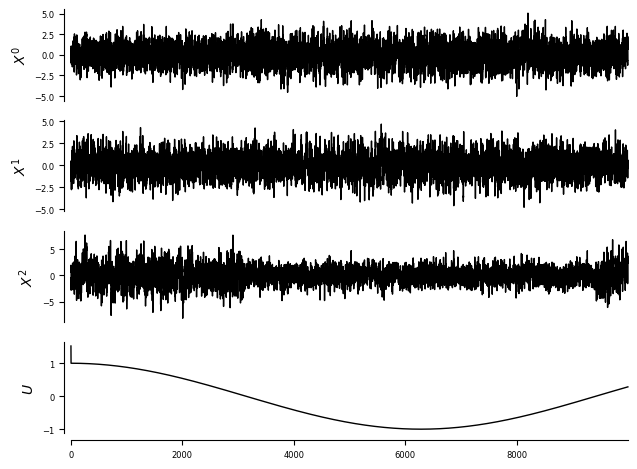

In [2]:
np.random.seed(42)
N = 4
T = 10000
data = np.random.randn(T, N)
datatime = np.arange(T)

# Simple unobserved confounder U that smoothly changes causal relations
U = np.cos(np.arange(T)*0.0005) #+ 0.1*np.random.randn(T)
c = 0.8
for t in range(1, T):
    if U[t] >= 0:
        data[t, 0] += 0.4*data[t-1, 0] 
        data[t, 1] += 0.5*data[t-1, 1] + 0.4*U[t]*data[t-1, 0]
        data[t, 2] += 0.6*data[t-1, 2] + data[t, 0] 
    else:
        data[t, 2] += 0.6*data[t-1, 2]         
        data[t, 0] += 0.4*data[t-1, 0] + 0.4*data[t, 2]
        data[t, 1] += 0.5*data[t-1, 1] + 0.4*U[t]*data[t-1, 0]
    data[t, 3] = U[t]

# Initialize dataframe object, specify variable names
var_names = [r'$X^{%d}$' % j for j in range(N-1) ] + [r'$U$']
dataframe_plot = pp.DataFrame(data, var_names=var_names)
tp.plot_timeseries(dataframe_plot); plt.show()

# For the analysis we use only the observed data
dataframe = pp.DataFrame(data[:,:3], var_names=var_names[:-1])

In [3]:
window_step=1000
window_length=1000
method='run_pcmciplus'
method_args={'tau_min':0, 'tau_max':2, 'pc_alpha':0.01}
conf_lev = 0.95
cond_ind_test = ParCorr(significance='analytic')

# Init
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cond_ind_test,
    verbosity=0)
# Run
results = pcmci.run_sliding_window_of(method=method, 
                                    method_args=method_args, 
                                    window_step=window_step,
                                    window_length=window_length,
                                    conf_lev = conf_lev)

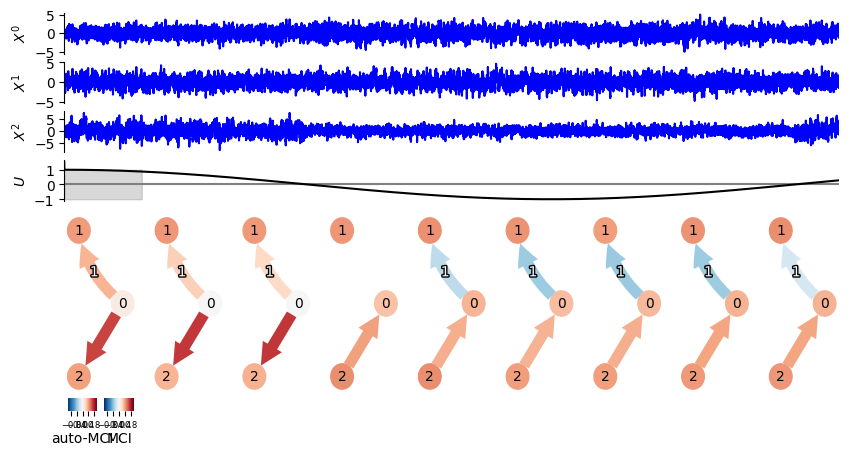

In [5]:
graphs = results['window_results']['graph']
val_matrices = results['window_results']['val_matrix']
n_windows = len(graphs)

mosaic = [['data %s' %j for i in range(n_windows)] for j in range(N)]
for n in range(N):
    mosaic.append(['graph %s' %i for i in range(n_windows)])
# print(mosaic)
fig, axs = plt.subplot_mosaic(mosaic = mosaic, figsize=(10, 5))

for j in range(N):
    ax = axs['data %s' %j]
    ax.axhline(0., color='grey')
    if j ==3:
        ax.fill_between(x=datatime, y1=-1, y2=1, where=datatime <= window_length, color='grey', alpha=0.3)
    
    if j == 3: color = 'black'
    else: color = 'blue'
    ax.plot(datatime, data[:,j], color=color)
#     axs['data %s' %j].axis('off') # xaxis.set_ticklabels([])
    for loc, spine in ax.spines.items():
        if loc != 'left':
            spine.set_color("none")
    
    ax.xaxis.set_ticks([])   
    ax.set_xlim(0., T)
    ax.set_ylabel(var_names[j])

for w in range(n_windows):
    if w == 0: show_colorbar=True
    else: show_colorbar = False
    tp.plot_graph(graphs[w], val_matrix=val_matrices[w], show_colorbar=show_colorbar,
                  fig_ax=(fig, axs['graph %s' %w]))

In [9]:
val_matrices

(9, 3, 3, 3)

Text(0, 0.5, 'Link Strength')

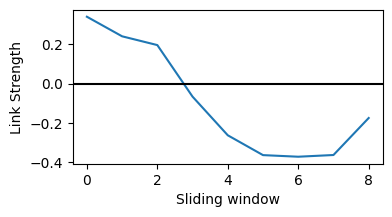

In [19]:
fig = plt.figure(figsize=(4, 2))
ax = fig.add_subplot(111)
ax.plot(list(range(n_windows)), val_matrices[:, 0, 1, 1])
ax.axhline(color='black')
ax.set_xlabel("Sliding window")
ax.set_ylabel("Link Strength")

In [8]:
val_matrices

array([[[[ 0.00000000e+00,  8.28852707e-02,  3.60194807e-03],
         [ 1.11209777e-02,  3.39165610e-01, -1.08867309e-02],
         [ 6.77947902e-01,  6.00871697e-04,  3.69772514e-02]],

        [[ 1.11209777e-02,  6.28142887e-02,  7.92016768e-02],
         [ 0.00000000e+00,  4.28886034e-01,  1.65868055e-02],
         [-1.63180733e-02,  5.26946215e-02,  2.36743632e-02]],

        [[ 6.77947902e-01,  2.22635963e-02,  4.41876576e-03],
         [-1.63180733e-02, -2.30813132e-02,  7.62598934e-02],
         [ 0.00000000e+00,  4.13663092e-01, -7.81735506e-02]]],


       [[[ 0.00000000e+00,  2.55511625e-02,  3.53823981e-02],
         [-5.43130307e-02,  2.39840731e-01,  7.51418065e-02],
         [ 7.09647353e-01,  1.24630272e-02,  5.53724648e-02]],

        [[-5.43130307e-02, -2.80108020e-02, -2.14897565e-02],
         [ 0.00000000e+00,  4.39945890e-01, -4.91316546e-02],
         [-3.00781338e-02, -5.32410353e-02,  7.77853298e-02]],

        [[ 7.09647353e-01, -3.81778423e-02, -6.93395123e-0